In [15]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker
import skimage.measure as skm
import copy
from scipy.ndimage import gaussian_filter
from mpl_toolkits.axes_grid1 import make_axes_locatable
%autosave 60

Autosaving every 60 seconds


In [2]:
m_in_parsec = 3.0856e16 # m/pc
c = 2.998e8 # m / s
sec_in_year = 31557600 # seconds
universe_age = 13.798e9 # age in years
sigmaSys = 0.005 # 5 mMag

In [3]:
def sigma_rand(mag, filterChoice):
    # Expression and values from table 2 and equation 4
    # of the LSST overview paper https://arxiv.org/pdf/0805.2366.pdf
    gammas = [.038, .039, .039, .039, .039, .039]
    mag5s = [23.78, 24.81, 24.35, 23.92, 23.34, 22.45]
    gamma = gammas[filterChoice]
    mag5 = mag5s[filterChoice]
    sigma = np.sqrt((0.04 - gamma) * 10**(0.4 * (mag - mag5)) + gamma * 10**(0.8 * (mag - mag5)))
    
    return sigma

def spectral_flux_density(mag):
    return 3631 * 10**(-mag/2.5) # in Janskys (Approx) (Power per area per wavelength)

def ab_mag(sfd):
    return -2.5 * np.log10(sfd/3631)

In [4]:
def sersicIntensity(r, n, rHalf=1, k=1, norm=1):
    b = 2*n - 1/3 + 4/(405*n) + 46/(25515*n**2) + 131/(1148175*n**3) - 2194697/(30690717750*n**4)
    return norm * np.exp(-b * ((r/rHalf)**(1/n) - 1)) * np.exp(-b)
#     return norm * np.exp(-k * r**(1/n))

def calculateFractionLensed(lensedRegionSize, sourceSize):
    x = lensedRegionSize / 2
    r = sourceSize / 2
    sourceArea = np.pi * r**2
    lensedArea = 2 * (x * np.sqrt(r**2 - x**2) + r**2 * np.arctan(x / np.sqrt(r**2 - x**2)))
    fracLensed = lensedArea / sourceArea
    return fracLensed

In [5]:
def lensed_quantities(tension, fString=1/2, sourceDiameter=1e4, distance=2e9):
    # galaxy <sourceDiameter> pc accross at <distance> pc away
    # With string lensing <fString> of the distance along line of sight (from observer)
    string_los_angle = np.pi/2 # angle string makes with line of sight
    source_obs_distance = distance # parsecs
    string_obs_distance = fString * source_obs_distance # parsec
    source_string_distance = source_obs_distance - string_obs_distance # parsec
    thetaE = 8 * np.pi * tension * np.sin(string_los_angle)
    gammaE = 50 # Dimensionless number for gravitational evaporation
    v_com = 600e3 # m/s
    lenString = universe_age * sec_in_year * c *(gammaE * tension) / m_in_parsec # parsecs
    tCross = lenString * m_in_parsec / (v_com * sec_in_year) # years
    tLens = ((string_obs_distance * source_string_distance / # pc times pc
                    (string_obs_distance + source_string_distance)) * m_in_parsec * # pc * m/pc
                    thetaE / (c / 2)) # m * s/m -> seconds
    loop_angular_size = lenString / string_obs_distance 
    lensed_region_physical_size = source_string_distance * thetaE # parsecs
    lensed_region_angular_size = lensed_region_physical_size / source_obs_distance
    fLensed = calculateFractionLensed(lensed_region_physical_size, sourceDiameter)
    
    lensed_quantities = dict(tCross=tCross,
                            tLens=tLens,
                            fLensed=fLensed,
                            lenString=lenString)
    
    return lensed_quantities

def dmag(flux_init, flux_final):
    return -2.5 * np.log10(flux_final / flux_init)

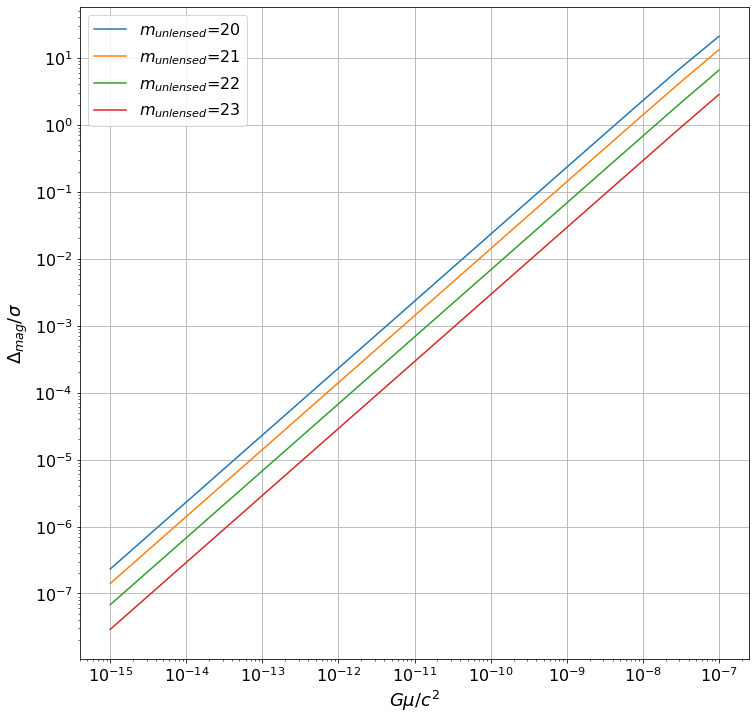

In [6]:
filters = ["u", "g", "r", "i", "z", "y"]
psfFWHMs = [.91, .87, .83, .8, .78, .76]
filterChoice = 2
cadence = 4 #  <cadence> days per observation
nObs = 360 // cadence
nObs_unlensed = nObs // 2
tensions = np.logspace(-15, -7, num=17)
lensing_data = lensed_quantities(tensions)
f_lensed = lensing_data['fLensed']
t_lensed = lensing_data['tLens'] # seconds

# nObs_lensed = np.minimum(nObs - nObs_unlensed, t_lensed // (60 * 60 * 24)) # right side is just days lensed
# observable = nObs_lensed > 0
# nObs_lensed = nObs_lensed[observable]
# tensions = tensions[observable]
# f_lensed = f_lensed[observable]
nObs_lensed = 1
nObs_unlensed = 1

unlensed_mags = np.arange(20, 24) # limiting mag in <filterChoice> band

fig, ax = plt.subplots(figsize = (12, 12))
ax.set_xlabel(r'$G\mu/c^2$', fontsize=18)
ax.set_ylabel(r'$\Delta_{mag} / \sigma$', fontsize=18)

ax.set_xticks(tensions)
ax.tick_params(labelsize=16)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(visible=True)

for unlensed_mag in unlensed_mags:
    sfd_u = spectral_flux_density(unlensed_mag)
    sfd_l = (1 + f_lensed) * sfd_u
    lensed_mag = ab_mag(sfd_l)
    deltaMag = dmag(sfd_u, sfd_l)

    sigmaR_unlensed = sigma_rand(unlensed_mag, filterChoice)/np.sqrt(nObs_unlensed)
    sigmaR_lensed = sigma_rand(lensed_mag, filterChoice)/np.sqrt(nObs_lensed)
    sigma_unlensed = np.sqrt(sigmaR_unlensed**2 + sigmaSys**2)
    sigma_lensed = np.sqrt(sigmaR_lensed**2 + sigmaSys**2)
    sigma_total = sigma_lensed + sigma_unlensed

    y = np.abs(deltaMag / sigma_total)

    ax.plot(tensions, y, label=r'$m_{unlensed}$='+f'{unlensed_mag}')

locmajx = matplotlib.ticker.LogLocator(base=10, numticks=100) 
locminx = matplotlib.ticker.LogLocator(base=10, subs=np.arange(2, 10) * .1, numticks=100) # subs=(0.2,0.4,0.6,0.8)
locmajy = matplotlib.ticker.LogLocator(base=10, numticks=100) 
locminy = matplotlib.ticker.LogLocator(base=10, subs=np.arange(2, 10) * .1, numticks=100) # subs=(0.2,0.4,0.6,0.8)

ax.yaxis.set_major_locator(locmajy)
ax.yaxis.set_minor_locator(locminy)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.xaxis.set_major_locator(locmajx)
ax.xaxis.set_minor_locator(locminx)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.legend(fontsize=16)
plt.show(fig)

In [7]:
rng = np.random.default_rng()
n_samples = 10**5
d_samples = rng.random(n_samples)
t_samples = d_samples*(1 - d_samples)
tmax = 1/4
t_ratios = t_samples / tmax

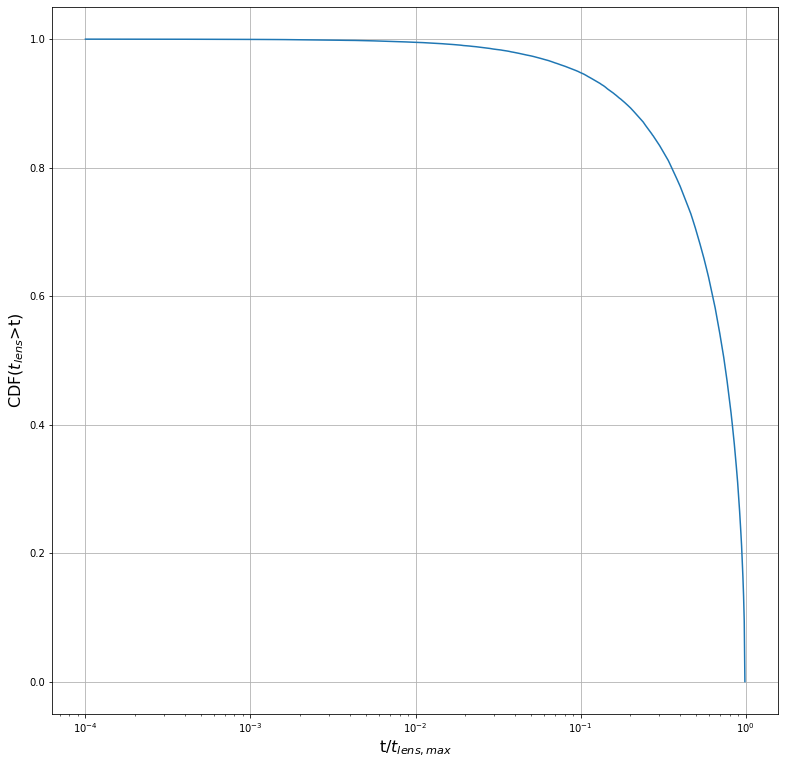

In [8]:
fig, ax = plt.subplots(figsize=(13, 13))
x = np.logspace(-4, 0, num=1000)
t_pdf, edges = np.histogram(t_ratios, bins=x)
t_cdf = np.cumsum(t_pdf)/n_samples

ax.semilogx(x[:-1], 1-t_cdf)
ax.grid(visible=True)
ax.set_ylabel(r'CDF($t_{lens}$>t)', fontsize=16)
ax.set_xlabel(r't/$t_{lens, max}$', fontsize=16)
plt.show()

211.5349414814623


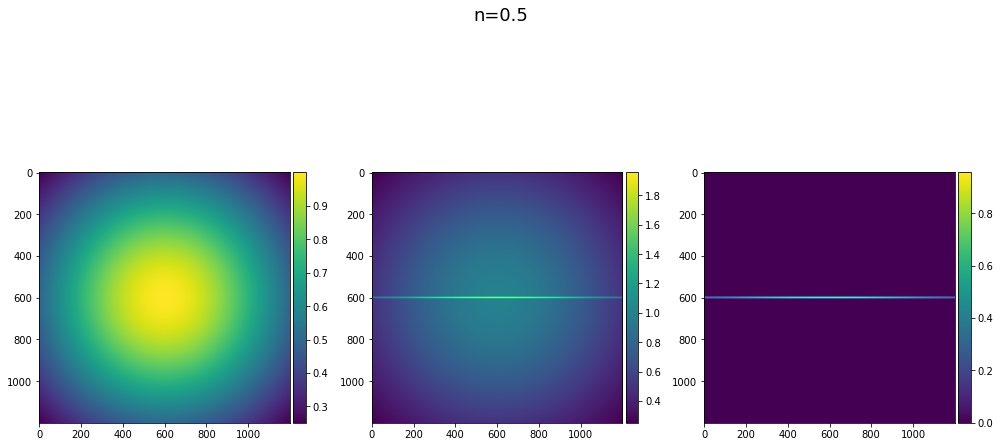

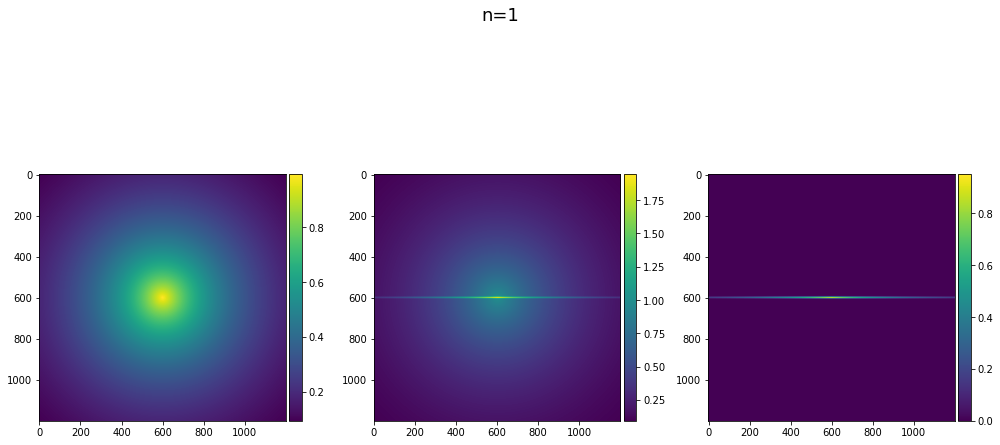

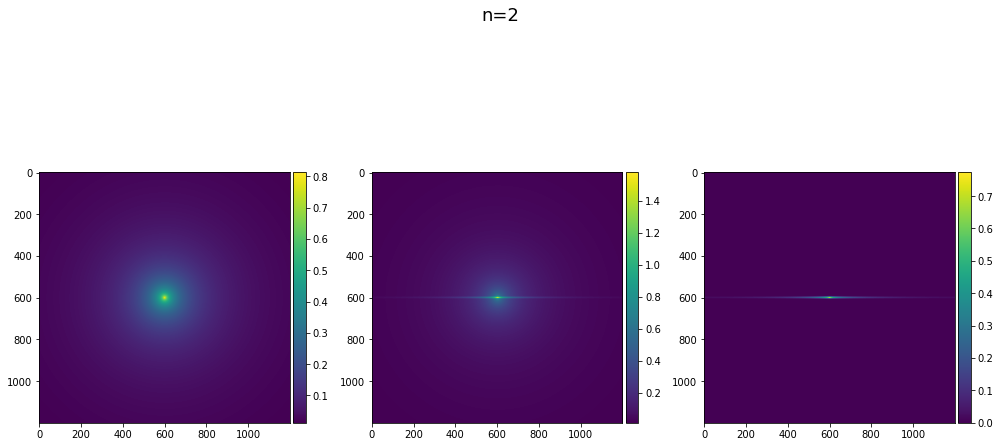

In [22]:
tension = 1e-9
fString = np.arange(1e-2, 1, 1e-2)
sourceDiameter = 1e4 # 10 kpc
distance = 2e9 # 2 Gpc
plateScale = .2
sourceAngularSize = (sourceDiameter / distance) * 180 * 60 * 60 / np.pi #arcSec
nRealPix = np.ceil(sourceAngularSize / plateScale)
plateScaleRatio = 200 # Sersic image to lsst image
nSersicPix = int(plateScaleRatio * nRealPix)
imageExtent = nRealPix * plateScale * np.pi / (180 * 60 * 60) * distance # pc

psfFWHM = psfFWHMs[filterChoice]
psfSigma = psfFWHM / (2 * np.sqrt(2 * np.log(2))) # arcSec
psfPix = psfSigma / plateScale
blockSize = int(nSersicPix / nRealPix)

lensingData = lensed_quantities(tension, fString=fString, 
                                sourceDiameter=sourceDiameter,
                                distance=distance)
fLensed = lensingData['fLensed']
lenString = lensingData['lenString'] # pc
print(lenString)

unlensedMag = 23
sfdU = spectral_flux_density(unlensedMag)
sersicN = [1/2, 1, 2]
# kFactor = [1, 1, 1]
# deltaMag = np.zeros((len(sersicN), len(fString)))

lightDecayFractions = [1/2, 1/2, 1/2]
x = np.linspace(-sourceDiameter//2, sourceDiameter//2, nSersicPix+1)
y = np.linspace(-sourceDiameter//2, sourceDiameter//2, nSersicPix+1)
x2 = x**2
y2 = y**2
y2 = y2.reshape(len(y2), 1) # Reshape to take advantage of broadcasting
sersicImgR = np.sqrt(x2 + y2)
sersicImgR = sersicImgR[:-1, :-1]

for i, n in enumerate(sersicN):
    fig, axs = plt.subplots(1, 3, figsize=(14, 8))
    lightDecayFraction = lightDecayFractions[i]
    plt.suptitle(f'n={n}', fontsize=18)
    sersicK = - np.log(lightDecayFraction) / (sourceDiameter/2)**(1/n)
#     sersicK *= kFactor[i]
        
    for j, f in enumerate(fLensed):
        sersicImg = sersicIntensity(sersicImgR, n, rHalf=sourceDiameter/2, k=sersicK)
        halfLightImg = copy.copy(sersicImg)
        halfLightImg[halfLightImg > sourceDiameter/2] = 0
        norm = sfdU / halfLightImg.sum()
        lensedIdxMin = int(((1 - f) * nSersicPix) / 2)
        lensedIdxMax = int(((1 + f) * nSersicPix) / 2)
#         sersicImg *= norm # Normalize to SFD
        lensedImg = copy.copy(sersicImg)
        lensedImg[lensedIdxMin: lensedIdxMax] *= 2
        sersicImg = gaussian_filter(sersicImg, psfPix)
        lensedImg = gaussian_filter(lensedImg, psfPix)
        
#         sersicImg = skm.block_reduce(sersicImg, block_size=(blockSize, blockSize))
#         lensedImg = skm.block_reduce(lensedImg, block_size=(blockSize, blockSize))
        
        diffImg = lensedImg - sersicImg
        im0 = axs[0].imshow(sersicImg)
        im1 = axs[1].imshow(lensedImg)
        im2 = axs[2].imshow(diffImg)
        
        for im, ax in zip([im0, im1, im2], axs.ravel()):
            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='5%', pad=0.05)
            fig.colorbar(im, cax=cax, orientation='vertical')
        break
    fig.tight_layout()
#     fig.subplots_adjust(right=0.8)
#     cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#     fig.colorbar(im, cax=cbar_ax)
    plt.show()

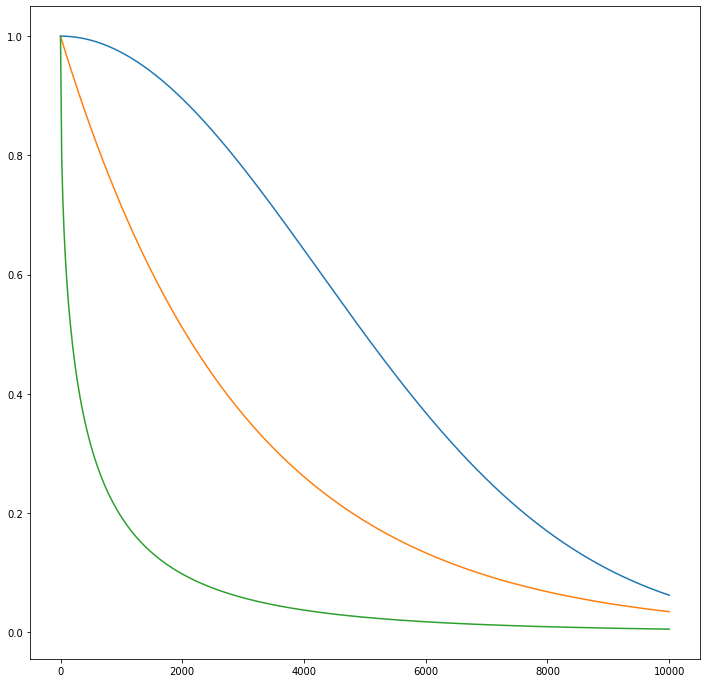

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
x = np.linspace(0, 1e4, 500)
xHalf = 5000
sersicK1 = - np.log(1/2) / (1e4/2)**(2/1)
sersicK2 = - np.log(1/2) / (1e4/2)**(1/1)
sersicK3 = - np.log(1/2) / (1e4/2)**(1/2)
y1 = sersicIntensity(x, 1/2, rHalf=xHalf, k=sersicK1)
y2 = sersicIntensity(x, 1, rHalf=xHalf, k=sersicK2)
y3 = sersicIntensity(x, 2, rHalf=xHalf, k=sersicK3)
ax.plot(x, y1)
ax.plot(x, y2)
ax.plot(x, y3)

# ax.set_ylim(0, 2)
plt.show()